# Questions:
1. Is S(t) not constant? If not, how are we reaching this conclusion (R-squared values are close to 1).
2. What would have happened if omicron had not entered the population? Would the delta wave still look the same (ie. does delta follow the normal SIR)?
3. Is the decrease in delta due to omicron (Is omicron decreasing S(t) so fast s.t. it is affecting the spread of delta?)? How does the selective sweep model tell us about this?


In [1]:
import numpy as np
import scipy.integrate as integrate
import random
import scipy.stats as stats
import numpy as np

import math
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Notation we use below.
arctan = np.arctan
cos = np.cos
det = np.linalg.det
exp = np.exp
inner = np.inner
log = np.log
matmul = np.matmul
norm = np.linalg.norm
odeint = integrate.odeint
pi = np.pi
quad = integrate.quad
randbinom = np.random.binomial
randexp = np.random.exponential
randnorm = np.random.normal
randperm = np.random.permutation
randuni = np.random.uniform
sin = np.sin
sqrt = np.sqrt

In [2]:
# access csv files, change file name as necessary
casesData = pd.read_csv('CDC052322.csv', skiprows=(0,1))
varData = pd.read_csv('CovidProps.csv')
# casesData[169:190]

In [3]:
# specify columns, convert to numpy
dates = pd.DataFrame(casesData, columns=['Date'])
avgCases = pd.DataFrame(casesData, columns=['7-Day Moving Avg'])
dates = pd.DataFrame.to_numpy(dates, dtype=str)
avgCases = pd.DataFrame.to_numpy(avgCases, dtype=int)

len(dates) # 846. START dates[15] = May Second.
dates2 = dates[15:]
avgCases = avgCases[15:]

# preallocate empty lists for biweekly dates and cases
biweeklyDates = []
biweeklyCases = []

n = 0
for i in range(36):
    biweeklyDates.append(dates2[n,0]) # why are we fetching the last 15 dates?
    # print(datestest[n,0])
    biweeklyCases.append(avgCases[n,0])
    n = n + 14 # printing every 14th date.

# fix the last date manually (Christmas week testing was skipped)
biweeklyDates[-1] = 'Dec 21 2021'
biweeklyCases[-1] = 162658

In [4]:
biweeklyDates# backwards in time.

['May  2 2022',
 'Apr 18 2022',
 'Apr  4 2022',
 'Mar 21 2022',
 'Mar  7 2022',
 'Feb 21 2022',
 'Feb  7 2022',
 'Jan 24 2022',
 'Jan 10 2022',
 'Dec 27 2021',
 'Dec 13 2021',
 'Nov 29 2021',
 'Nov 15 2021',
 'Nov  1 2021',
 'Oct 18 2021',
 'Oct  4 2021',
 'Sep 20 2021',
 'Sep  6 2021',
 'Aug 23 2021',
 'Aug  9 2021',
 'Jul 26 2021',
 'Jul 12 2021',
 'Jun 28 2021',
 'Jun 14 2021',
 'May 31 2021',
 'May 17 2021',
 'May  3 2021',
 'Apr 19 2021',
 'Apr  5 2021',
 'Mar 22 2021',
 'Mar  8 2021',
 'Feb 22 2021',
 'Feb  8 2021',
 'Jan 25 2021',
 'Jan 11 2021',
 'Dec 21 2021']

In [5]:
# forward in time.
biweeklyDates.reverse()
biweeklyDates # forward in time.

['Dec 21 2021',
 'Jan 11 2021',
 'Jan 25 2021',
 'Feb  8 2021',
 'Feb 22 2021',
 'Mar  8 2021',
 'Mar 22 2021',
 'Apr  5 2021',
 'Apr 19 2021',
 'May  3 2021',
 'May 17 2021',
 'May 31 2021',
 'Jun 14 2021',
 'Jun 28 2021',
 'Jul 12 2021',
 'Jul 26 2021',
 'Aug  9 2021',
 'Aug 23 2021',
 'Sep  6 2021',
 'Sep 20 2021',
 'Oct  4 2021',
 'Oct 18 2021',
 'Nov  1 2021',
 'Nov 15 2021',
 'Nov 29 2021',
 'Dec 13 2021',
 'Dec 27 2021',
 'Jan 10 2022',
 'Jan 24 2022',
 'Feb  7 2022',
 'Feb 21 2022',
 'Mar  7 2022',
 'Mar 21 2022',
 'Apr  4 2022',
 'Apr 18 2022',
 'May  2 2022']

In [6]:
# STARTING DATE: 12/21 - 5/02
percentDelta = pd.DataFrame(varData, columns=['perc_deltas'])
percentOmicron = pd.DataFrame(varData, columns=['perc_omicrons'])
percentBA45 = pd.DataFrame(varData, columns=['perc_ba45'])

percentDelta = pd.DataFrame.to_numpy(percentDelta, dtype=float)
percentOmicron = pd.DataFrame.to_numpy(percentOmicron, dtype=float)
percentBA45 = pd.DataFrame.to_numpy(percentBA45, dtype=float)


# append num_ variables to varData

numDelta = []
numOmicron = []
numBA45 = []
for i in range(len(biweeklyDates)):
    delta = percentDelta[i,0]*biweeklyCases[i]
    numDelta.append(delta)
    
    omicron = percentOmicron[i,0]*biweeklyCases[i]
    numOmicron.append(omicron)
    
    BA45 = percentBA45[i,0]*biweeklyCases[i]
    numBA45.append(BA45)
    


finalTable = [['Dates', 'Percent Delta', 'Percent Omicron', 'Percent Ba45', '# of Delta', '# of Omicron', '# of BA45', '# of Total Cases']]
for i in range(len(biweeklyDates)):
    finalTable.append([biweeklyDates[i], percentDelta[i][0], percentOmicron[i][0], percentBA45[i][0], numDelta[i], numOmicron[i], numBA45[i], biweeklyCases[i]])

In [7]:
varData["numDelta"] = numDelta
varData["numOmicron"] = numOmicron
varData["numBA45"] = numBA45
varData["biweeklyDates"] = biweeklyDates
varData["biweeklyCases"] = biweeklyCases
varData # note: before sept. 2021 all the percentages (delta, omicron, ba45) do not add to 1 because of the presence of beta.

# varData.to_csv('covid_variants_cases.csv')


,week,total_sequences,deltas,omicrons,ba45,perc_deltas,perc_omicrons,perc_ba45,numDelta,numOmicron,numBA45,biweeklyDates,biweeklyCases
0,2020-12-21,36771,11,0,0,0.000299,0.000000,0.000000,18.135297,0.000000,0.000000,Dec 21 2021,60623
1,2021-01-11,35804,4,0,0,0.000112,0.000000,0.000000,4.172048,0.000000,0.000000,Jan 11 2021,37344
2,2021-01-25,31768,1,0,0,0.000031,0.000000,0.000000,0.786357,0.000000,0.000000,Jan 25 2021,24981
3,2021-02-08,34820,1,0,0,0.000029,0.000000,0.000000,0.767088,0.000000,0.000000,Feb 8 2021,26710
4,2021-02-22,37323,2,0,0,0.000054,0.000000,0.000000,2.066715,0.000000,0.000000,Feb 22 2021,38568
5,2021-03-08,48910,5,0,0,0.000102,0.000000,0.000000,7.936312,0.000000,0.000000,Mar 8 2021,77633
6,2021-03-22,66582,23,0,0,0.000345,0.000000,0.000000,85.241837,0.000000,0.000000,Mar 22 2021,246764
7,2021-04-05,77663,97,0,0,0.001249,0.000000,0.000000,869.539060,0.000000,0.000000,Apr 5 2021,696196
8,2021-04-19,66041,467,0,0,0.007071,0.000000,0.000000,5381.775291,0.000000,0.000000,Apr 19 2021,761066
9,2021-05-03,49602,837,0,0,0.016874,0.000000,0.000000,4314.156042,0.000000,0.000000,May 3 2021,255664


In [8]:
### Old (Skip)

# access csv files, change file name as necessary
casesData = pd.read_csv('CDC052322.csv', skiprows=(0,1))
varData = pd.read_csv('CovidProps.csv')

# specify columns, convert to numpy
dates = pd.DataFrame(casesData, columns=['Date'])
avgCases = pd.DataFrame(casesData, columns=['7-Day Moving Avg'])
dates = pd.DataFrame.to_numpy(dates, dtype=str)
avgCases = pd.DataFrame.to_numpy(avgCases, dtype=int)

percentDelta = pd.DataFrame(varData, columns=['perc_deltas'])
percentOmicron = pd.DataFrame(varData, columns=['perc_omicrons'])
percentBA45 = pd.DataFrame(varData, columns=['perc_BA45'])

percentDelta = pd.DataFrame.to_numpy(percentDelta, dtype=float)
percentOmicron = pd.DataFrame.to_numpy(percentOmicron, dtype=float)
percentBA45 = pd.DataFrame.to_numpy(percentBA45, dtype=float)

# preallocate empty lists for biweekly dates and cases
biweeklyDates = []
biweeklyCases = []
n = None

#fill in biweekly dates/cases based on starting date (Dec 21 2021)
for i in range(len(dates[:,0])):
    j = len(dates[:,0]) - 1 - i
    if dates[j,0] == 'Dec 21 2021':
        biweeklyDates.append(dates[j,0])
        biweeklyCases.append(avgCases[j,0])
        n = j
        break

for i in range(35):
    n = n - 14
    biweeklyDates.append(dates[n,0])
    biweeklyCases.append(avgCases[n,0])


numDelta = []
numOmicron = []
numBA45 = []
for i in range(len(biweeklyDates)):
    delta = percentDelta[i,0]*biweeklyCases[i]
    numDelta.append(delta)
    omicron = percentOmicron[i,0]*biweeklyCases[i]
    numOmicron.append(omicron)
    BA45 = percentBA45[i,0]*biweeklyCases[i]
    numBA45.append(BA45)
    


finalTable = [['Dates', 'Percent Delta', 'Percent Omicron', 'Percent Ba45', '# of Delta', '# of Omicron', '# of BA45', '# of Total Cases']]
for i in range(len(biweeklyDates)):
    finalTable.append([biweeklyDates[i], percentDelta[i][0], percentOmicron[i][0], percentBA45[i][0], numDelta[i], numOmicron[i], numBA45[i], biweeklyCases[i]])
    

In [9]:
biweeklyDates

['Dec 21 2021',
 'Jan  4 2022',
 'Jan 18 2022',
 'Feb  1 2022',
 'Feb 15 2022',
 'Mar  1 2022',
 'Mar 15 2022',
 'Mar 29 2022',
 'Apr 12 2022',
 'Apr 26 2022',
 'May 10 2022',
 'Jan 29 2020',
 'Feb 12 2020',
 'Feb 26 2020',
 'Mar 11 2020',
 'Mar 25 2020',
 'Apr  8 2020',
 'Apr 22 2020',
 'May  6 2020',
 'May 20 2020',
 'Jun  3 2020',
 'Jun 17 2020',
 'Jul  1 2020',
 'Jul 15 2020',
 'Jul 29 2020',
 'Aug 12 2020',
 'Aug 26 2020',
 'Sep  9 2020',
 'Sep 23 2020',
 'Oct  7 2020',
 'Oct 21 2020',
 'Nov  4 2020',
 'Nov 18 2020',
 'Dec  2 2020',
 'Dec 16 2020',
 'Dec 30 2020']

In [10]:
len(numDelta) # len(numDelta) = 35

36

In [11]:
N = 329000000
propDelta = [numDelta[i]/N for i in range(len(numDelta))]
propDelta
propOmicron = [numOmicron[i]/N for i in range(len(numOmicron))]
propAll = [biweeklyCases[i]/N for i in range(len(biweeklyCases))]

In [12]:
# finalTable # 36 time points

## Start here if you have covid_variants_cases.csv

In [13]:
covid_vc = pd.read_csv('covid_variants_cases.csv') # 22a-c
covid_vc[:]


,Unnamed: 0,Unnamed: 0.1,week,total_sequences,deltas,omicrons,ba45,perc_deltas,perc_omicrons,perc_ba45,numDelta,numOmicron,numBA45,biweeklyDates,biweeklyCases,logistic_perc_deltas,logistic_perc_omicron,logistic_perc_ba45,date_time
0,0,0,2020-12-21,36771,11,0,0,0.000299,0.000000,0.000000,18.135297,0.000000,0.000000,Dec 21 2021,60623,-8.114270,-inf,-inf,2020-12-21
1,1,1,2021-01-11,35804,4,0,0,0.000112,0.000000,0.000000,4.172048,0.000000,0.000000,Jan 11 2021,37344,-9.099409,-inf,-inf,2021-01-11
2,2,2,2021-01-25,31768,1,0,0,0.000031,0.000000,0.000000,0.786357,0.000000,0.000000,Jan 25 2021,24981,-10.366183,-inf,-inf,2021-01-25
3,3,3,2021-02-08,34820,1,0,0,0.000029,0.000000,0.000000,0.767088,0.000000,0.000000,Feb 8 2021,26710,-10.457918,-inf,-inf,2021-02-08
4,4,4,2021-02-22,37323,2,0,0,0.000054,0.000000,0.000000,2.066715,0.000000,0.000000,Feb 22 2021,38568,-9.834164,-inf,-inf,2021-02-22
5,5,5,2021-03-08,48910,5,0,0,0.000102,0.000000,0.000000,7.936312,0.000000,0.000000,Mar 8 2021,77633,-9.188197,-inf,-inf,2021-03-08
6,6,6,2021-03-22,66582,23,0,0,0.000345,0.000000,0.000000,85.241837,0.000000,0.000000,Mar 22 2021,246764,-7.970350,-inf,-inf,2021-03-22
7,7,7,2021-04-05,77663,97,0,0,0.001249,0.000000,0.000000,869.539060,0.000000,0.000000,Apr 5 2021,696196,-6.684173,-inf,-inf,2021-04-05
8,8,8,2021-04-19,66041,467,0,0,0.007071,0.000000,0.000000,5381.775291,0.000000,0.000000,Apr 19 2021,761066,-4.944605,-inf,-inf,2021-04-19
9,9,9,2021-05-03,49602,837,0,0,0.016874,0.000000,0.000000,4314.156042,0.000000,0.000000,May 3 2021,255664,-4.064944,-inf,-inf,2021-05-03


In [14]:
# Change dates to datetimes.
from datetime import datetime

ds = []

for d in range(len(covid_vc["week"])):
    # print(datetime.strptime(covid_vc["week"][d], "%Y-%m-%d"))
    ds.append(datetime.strptime(covid_vc["week"][d], "%Y-%m-%d"))
ds
covid_vc["date_time"] = ds

In [15]:
covid_vc["date_time"][15] - covid_vc["date_time"][9]

Timedelta('84 days 00:00:00')

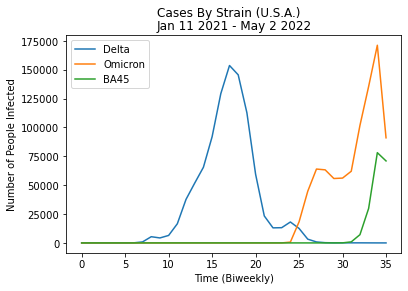

In [16]:
fig, ax = plt.subplots()
ax.plot(covid_vc["numDelta"], label='Delta')
ax.plot(covid_vc["numOmicron"], label='Omicron')
ax.plot(covid_vc["numBA45"], label='BA45')
legend = ax.legend(loc='upper left')

plt.title('Jan 11 2021 - May 2 2022')
plt.suptitle("Cases By Strain (U.S.A.)")
plt.xlabel('Time (Biweekly)')
plt.ylabel('Number of People Infected')

fig.savefig(r'/Users/JennyH/Documents/math690/figures/num_cases_usa.pdf', bbox_inches="tight")

Text(0, 0.5, 'Proportion of Population Infected')

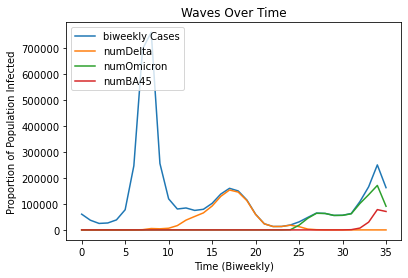

In [17]:
fig, ax = plt.subplots()
ax.plot(covid_vc["biweeklyCases"], label='biweekly Cases')
ax.plot(covid_vc["numDelta"], label='numDelta')
ax.plot(covid_vc["numOmicron"], label='numOmicron')
ax.plot(covid_vc["numBA45"], label='numBA45')
legend = ax.legend(loc='upper left')
plt.title('Waves Over Time')
plt.xlabel('Time (Biweekly)')
plt.ylabel('Proportion of Population Infected')

# Reasons the proportion infected is small (yet it is still characteristic of the SIR shape)
1. Disease is spreading over only small pockets (or region) of the USA (so the denom is much smaller than 330M.)
2. We are graphing the number of NEW cases, rather than I(t) in these graphs.

In [18]:
# SIR Ordinary Differential Equation
def V(x,t,beta,gamma):
    return [-beta*x[0]*x[1], beta*x[0]*x[1]-gamma*x[1], gamma*x[1]] # [s(t), i(t), r(t)]

In [19]:
# Fitting a range of different beta values. Play around with this!
beta_grid = np.linspace(start=.2, stop=1, num=20)
print(beta_grid)

[0.2        0.24210526 0.28421053 0.32631579 0.36842105 0.41052632
 0.45263158 0.49473684 0.53684211 0.57894737 0.62105263 0.66315789
 0.70526316 0.74736842 0.78947368 0.83157895 0.87368421 0.91578947
 0.95789474 1.        ]


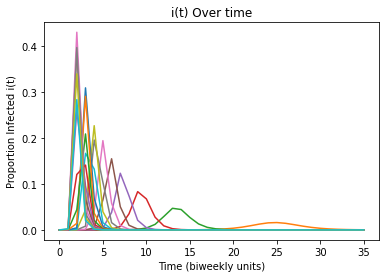

In [20]:
# Population size
N = 33000000

# fix gamma (5 day recovery)
gamma = 0.2

for beta in beta_grid: 
    
    # Initial condition; i_0 is the initial number of infected people
    i_0 = 1/N
    x = [1-i_0, i_0, 0]

    # Time
    days = 35*14
    steps = 36
    T = np.linspace(0,days,steps)

    # Integrate (aka solve) the ODE; phi is the solution phi=[s(t), i(t), r(t)]
    phi = odeint(V, x, T, args=(beta,gamma)) 

    # s compartment
    s = phi[:,0]
    # i compartment
    i = phi[:,1]
    # r compartment
    r = phi[:,2]
    
    
    # Plots of the solved differential equations
    plt.plot(T/14,i,label="i")
    plt.xlabel('Time (biweekly units)')
    plt.ylabel('Proportion Infected i(t)')
    plt.title('i(t) Over time')

3.03030303030303e-11
[  0.  14.  28.  42.  56.  70.  84.  98. 112. 126. 140. 154. 168. 182.
 196. 210. 224. 238. 252. 266. 280. 294. 308. 322. 336. 350. 364. 378.
 392. 406. 420. 434. 448. 462. 476. 490.]


Text(0.5, 1.0, 'i(t) Over time')

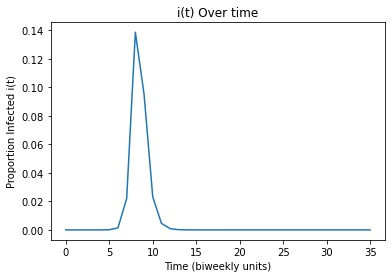

In [21]:
# Beta Wave Approximation

# Initial condition; i_0 is the initial number of infected people
i_0 = 1/(1000*N)
print(i_0)
x = [1-i_0, i_0, 0]

# Time
days = 35*14
steps = 36
T = np.linspace(0,days,steps)
print(T)
# Integrate (aka solve) the ODE; phi is the solution phi=[s(t), i(t), r(t)]
phi = odeint(V, x, T, args=(0.4,gamma)) 

# s compartment
s = phi[:,0]
# i compartment
i = phi[:,1]
# r compartment
r = phi[:,2]


# Plots of the solved differential equations
plt.plot(T/14,i,label="i")
plt.xlabel('Time (biweekly units)')
plt.ylabel('Proportion Infected i(t)')
plt.title('i(t) Over time')

In [22]:
# What effect did omicron have on delta spread?
# Case 1: graph of no omicron. (how much did delta's s(t) change due to omicron.)
# Case 2: graph with omicron.

3.03030303030303e-11
[  0.  14.  28.  42.  56.  70.  84.  98. 112. 126. 140. 154. 168. 182.
 196. 210. 224. 238. 252. 266. 280. 294. 308. 322. 336. 350. 364. 378.
 392. 406. 420. 434. 448. 462. 476. 490.]


Text(0.5, 1.0, 'i(t) Over time')

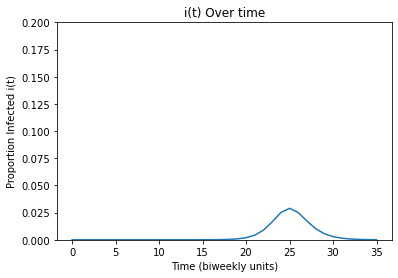

In [23]:
# Delta Wave Approximation

# Initial condition; i_0 is the initial number of infected people
i_0 = 1/(1000*N)
print(i_0)
x = [1-i_0, i_0, 0]

# Time
days = 35*14
steps = 36
T = np.linspace(0,days,steps)
print(T)
# Integrate (aka solve) the ODE; phi is the solution phi=[s(t), i(t), r(t)]
phi = odeint(V, x, T, args=(0.26,gamma)) 

# s compartment
s = phi[:,0]
# i compartment
i = phi[:,1]
# r compartment
r = phi[:,2]


# Plots of the solved differential equations
plt.plot(T/14,i,label="i")
plt.ylim(0, 0.2)
plt.xlabel('Time (biweekly units)')
plt.ylabel('Proportion Infected i(t)')
plt.title('i(t) Over time')

Although the shape of the Beta curve is very similar to an approximate [beta, gamma] = [0.4, 0.2] (with r0 = 2) the proportion truly infected in the data is quite low.

### Logistic Growth Model
#### DOES THE PROPORTION OF A MORE VIRULENT STRAIN FIT A LOGISTIC GROWTH CURVE?

In [24]:
def L(x,t,beta,gamma):
    '''
    logistic growth curve differential equation.
    '''
    return [-beta*x[0]*x[1], x[1]*(1-x[1])*beta*1] # [ignore, i_2_prop]

In [25]:
# Play around with this grid of values.
diff_beta_grid = np.linspace(start=.1, stop=.2, num=10)
diff_beta_grid

array([0.1       , 0.11111111, 0.12222222, 0.13333333, 0.14444444,
       0.15555556, 0.16666667, 0.17777778, 0.18888889, 0.2       ])

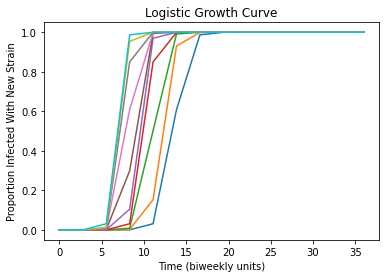

In [26]:
# Population size of USA
N = 329000000

for diff_beta in diff_beta_grid: 
    
    # proportions of i_1 and i_2
    prop_i_2 = 1/N # initial proportion of variant 2: i_2/(i_2+i_1) (find what epsilon*N)
    x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

    
    # Time units
    days = 14*36 # two weeks * 36 
    steps = 14 # every 2 weeks
    T = np.linspace(0,days,steps)

    # Integrate (aka solve) the ODE; the logistic_vector is the solution.
    logistic_vector = odeint(L, x, T, args=(diff_beta, gamma)) 

    i_logistic_curve = logistic_vector[:,1]

    # plot
    plt.plot(T/14,i_logistic_curve,label="Logistic Growth")
    plt.xlabel('Time (biweekly units)')
    plt.ylabel('Proportion Infected With New Strain')
    plt.title('Logistic Growth Curve')

## Code to solve logistic equations

In [27]:
def solve_logistic(y0, y1, delta_t):
    '''
    param:
    y0 - initial proportion infectious
    y1 - final proportion infectious
    delta_t - change in time (days)
    return: lambda = beta_2 - beta_1
    '''
    b = 1/y0 - 1
    diff_b = -1/delta_t * log((1/b)*(1/y1 - 1))
    
    return diff_b

In [28]:
# Beta to delta
# These two data points give the start to end of the logistic growth curve.

# (date1, percentdelta) = (May 3, 2021, 0.016874)
# (date2, percentdelta) = (Jul 26 2021, 0.899738)

print(solve_logistic(0.016874, 0.899738, 84)) # 0.0745
diff_betadelta = solve_logistic(0.016874, 0.899738, 84)

# Beta to delta 2
# These two data points give the start to end of the logistic growth curve.

# (date1, percentdelta) = (May 3, 2021, 0.016874)
# (date2, percentdelta) = (June 14, 2021, 0.446455)

print(solve_logistic(0.016874, 0.446455, 42)) # 0.0916
diff_betadelta_halfway = solve_logistic(0.016874, 0.446455, 42)

### --- ### --- ###

# Delta to omicron BA1/2/3
# These two data points give the start to end of the logistic growth curve.

# (date1, percentOmicron) = (Nov 29 2021, 0.037709327)
# (date2, percentOmicron) = (Jan 10 2022, 0.986774)

print(solve_logistic(0.037709327, 0.986774, 42)) # 0.1798
diff_omicronba123 = solve_logistic(0.037709327, 0.986774, 42)

# Delta to omicron BA1/2/3
# These two data points give the start to end of the logistic growth curve.

# (date1, percentOmicron) = (Nov 29 2021, 0.037709327)
# (date2, percentOmicron) = (Dec 13 2021, 0.591637)

print(solve_logistic(0.037709327, 0.591637, 14)) # 0.258
diff_omicronba123_halfway = solve_logistic(0.037709327, 0.591637, 14)

### --- ### --- ###

# Omicron BA1/2/3 to BA4/5
# These two data points give the start to end of the logistic growth curve.

# (date1, percentBA4/5) = (Mar 21 2022, 0.065300)
# (date2, percentBA4/5) = (May 2 2022, 0.436607)

print(solve_logistic(0.065300, 0.436607, 42)) # 0.0572
diff_ba123_ba45 = solve_logistic(0.065300, 0.436607, 42)


0.0745152400630254
0.09166568754617174
0.1798015605426319
0.25786756299515484
0.057292610287515644


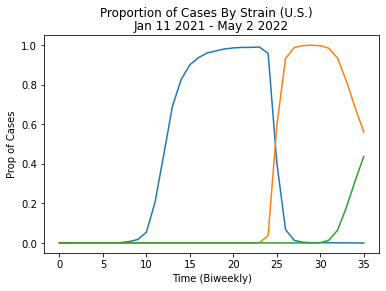

In [29]:
# Data From True Delta Props.
fig, ax = plt.subplots()
ax.plot(covid_vc["perc_deltas"], label='Prop of Cases Omicron')
ax.plot(covid_vc["perc_omicrons"], label='Prop of Cases Omicron')
ax.plot(covid_vc["perc_ba45"], label='Prop of Cases Omicron')

plt.title('Jan 11 2021 - May 2 2022')
plt.suptitle("Proportion of Cases By Strain (U.S.)")
plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Cases')

fig.savefig(r'/Users/JennyH/Documents/math690/figures/proportion_strain_USA.pdf', bbox_inches="tight")

Text(0.5, 0.98, 'Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)')

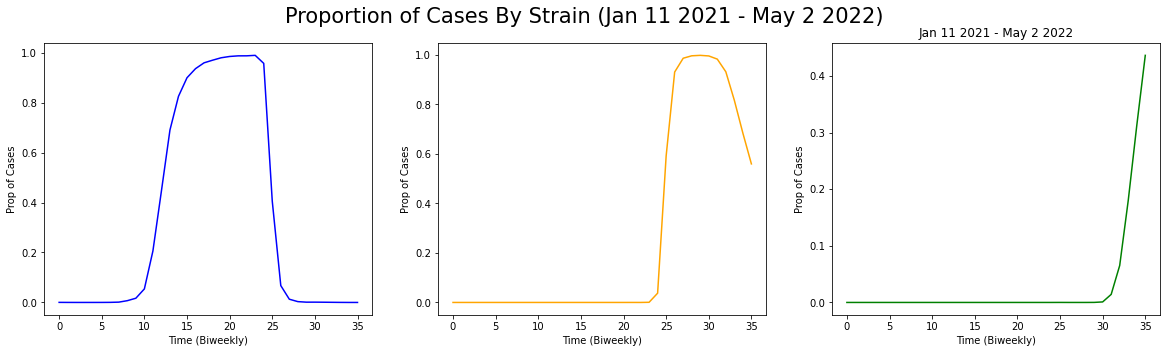

In [30]:
# Data from the 3 waves.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
fig.suptitle('Variant Competition')
plt.title('Jan 11 2021 - May 2 2022')

ax1.plot(covid_vc["perc_deltas"], label='Prop of Cases Omicron', color = 'blue')
ax1.set_xlabel('Time (Biweekly)')
ax1.set_ylabel('Prop of Cases') 

ax2.plot(covid_vc["perc_omicrons"], label='Prop of Cases Omicron', color = 'orange')
ax2.set_xlabel('Time (Biweekly)')
ax2.set_ylabel('Prop of Cases') 

ax3.plot(covid_vc["perc_ba45"], label='Prop of Cases Omicron', color = 'green')
ax3.set_xlabel('Time (Biweekly)')
ax3.set_ylabel('Prop of Cases') 

fig.suptitle("Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)", size=21)
# fig.subtitle('Jan 11 2021 - May 2 2022')

## Below, code numerically solves the logistic curve functions using the b_i-b_j found.

In [31]:
# proportions of beta to delta 
prop_i_2 = 0.0168 # initial proportion of variant 2: i_2/(i_2+i_1)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 35*14 # two weeks * 36 data points
steps = 36 # number of time points to output.
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector1 = odeint(L, x, T, args=(diff_betadelta, gamma)) 

betadelta = logistic_vector1[:,1]

In [32]:
# Calculating for the halfway mark (diff_betadelta_halfway).
# proportions of beta to delta 
prop_i_2 = 0.0168 # initial proportion of variant 2: i_2/(i_2+i_1)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 35*14 # two weeks * 36 data points
steps = 36 # number of time points to output.
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector1 = odeint(L, x, T, args=(diff_betadelta_halfway, gamma)) 

betadelta_halfway = logistic_vector1[:,1]

In [33]:
# proportions of delta to omicron
prop_i_2 = 0.037709327 # initial proportion of variant 2: i_2/(i_2+i_1)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 35*14 # two weeks * 36 data points
steps = 36 # number of time points to output.
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector2 = odeint(L, x, T, args=(diff_omicronba123, gamma))


delta_omicron12 = logistic_vector2[:,1]

In [34]:
# proportions of delta to omicron halfway mark (diff_betadelta_halfway).
prop_i_2 = 0.037709327 # initial proportion of variant 2: i_2/(i_2+i_1)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 35*14 # two weeks * 36 data points
steps = 36 # number of time points to output.
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector2 = odeint(L, x, T, args=(diff_omicronba123_halfway, gamma))


delta_omicron12_halfway = logistic_vector2[:,1]

In [35]:
# proportions of omicron1/2/3 to BA4/5
prop_i_2 = 0.065300 # initial proportion of variant 2: i_2/(i_2+i_1) (find what epsilon*N)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 35*14 # two weeks * 36 data points
steps = 36 # number of time points to output.
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector3 = odeint(L, x, T, args=(diff_ba123_ba45, gamma))


ba123_ba45 = logistic_vector3[:,1]

In [36]:
# For creating aligned plots: Align the start times of observed waves with the logistic growth curve.

# beta to delta
starting_frame = [0]*9 # start from May 3rd, which is the 9th datapoint in covid_vc
betadelta = starting_frame + list(betadelta)
betadelta_halfway = starting_frame + list(betadelta_halfway)
# delta to omicron
starting_frame = [0]*24
delta_omicron12 = starting_frame + list(delta_omicron12)
delta_omicron12_halfway = starting_frame + list(delta_omicron12_halfway)
# omicron to ba4/5
starting_frame = [0]*32
ba123_ba45 = starting_frame + list(ba123_ba45)

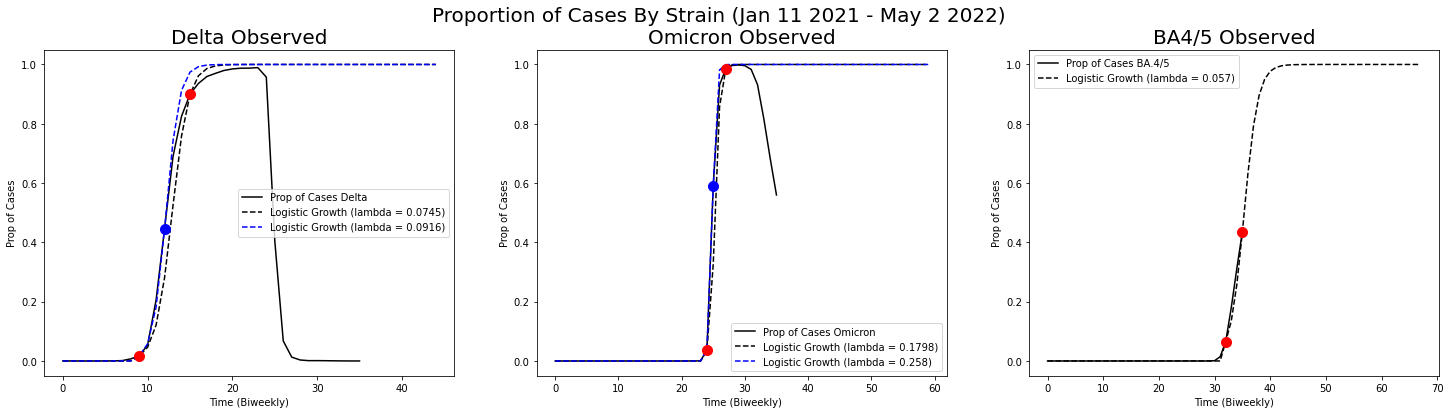

In [74]:
# Corresponding logistic growth curves with estimated b2-b1.
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(25, 6)

ax[0].plot(covid_vc["perc_deltas"], color='black', label='Prop of Cases Delta')
ax[0].plot(betadelta, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.0745)')
ax[0].plot(betadelta_halfway, color='blue', linestyle = '--', label='Logistic Growth (lambda = 0.0916)')

ax[0].set_xlabel('Time (Biweekly)')
ax[0].set_ylabel('Prop of Cases')
ax[0].set_title("Delta Observed", fontsize='20')
ax[0].plot(9, 0.016874, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[0].plot(12, 0.4465, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
ax[0].plot(15, 0.899, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[0].legend()

ax[1].plot(covid_vc["perc_omicrons"], color='black', label='Prop of Cases Omicron')
ax[1].plot(delta_omicron12, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.1798)')
ax[1].plot(delta_omicron12_halfway, color='blue', linestyle = '--', label='Logistic Growth (lambda = 0.258)')
ax[1].set_xlabel('Time (Biweekly)')
ax[1].set_ylabel('Prop of Cases') 
ax[1].set_title("Omicron Observed", fontsize='20')
ax[1].plot(24, .0377, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[1].plot(25, 0.591, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
ax[1].plot(27, .986, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[1].legend()

ax[2].plot(covid_vc["perc_ba45"], color='black', label='Prop of Cases BA.4/5')
ax[2].plot(ba123_ba45, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.057)')
ax[2].set_xlabel('Time (Biweekly)')
ax[2].set_ylabel('Prop of Cases')
ax[2].set_title("BA4/5 Observed", fontsize='20')
ax[2].plot(32, .0653, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[2].plot(35, 0.4366, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[2].legend()

fig.suptitle("Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)", fontsize='20')

# fig.savefig(r'/Users/JennyH/Documents/math690/figures/variant_competition_logistic.pdf', bbox_inches="tight")
fig.savefig('variant_competition_logistic_halfwaypoint.pdf')

In [38]:
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=80)

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

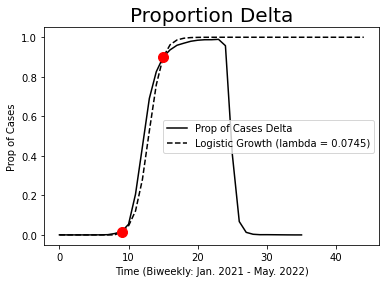

In [39]:
plt.plot(covid_vc["perc_deltas"], color='black', label='Prop of Cases Delta')
plt.plot(betadelta, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.0745)')

plt.xlabel('Time (Biweekly: Jan. 2021 - May. 2022)')
plt.ylabel('Prop of Cases')
plt.title("Proportion Delta", fontsize='20')
plt.plot(9, 0.016874, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
# ax[0].plot(12, 0.4465, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
plt.plot(15, 0.899, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.legend()

plt.savefig(r'/Users/JennyH/Documents/math690/figures/logistic_delta.pdf', bbox_inches="tight")

In [59]:
delta_omicron12[20:30]

[0,
 0,
 0,
 0,
 0.037709327,
 0.32691154886270646,
 0.8575434521653023,
 0.9867739894695537,
 0.9989197473464164,
 0.9999127557419176]

In [62]:
list_perc_omicron = list(covid_vc["perc_omicrons"])

In [ ]:
### list_perc_omicron[20:40] 

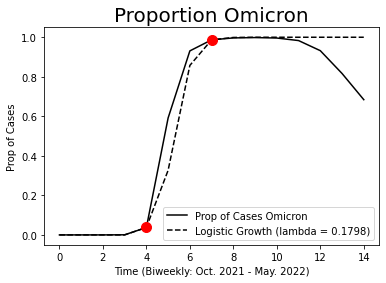

In [78]:
plt.plot(list_perc_omicron[20:35], color='black', label='Prop of Cases Omicron')
plt.plot(delta_omicron12[20:35], color='black', linestyle = '--', label='Logistic Growth (lambda = 0.1798)')
# ax[1].plot(delta_omicron12_halfway, color='blue', linestyle = '--', label='Logistic Growth (lambda = 0.258)')
plt.xlabel('Time (Biweekly: Oct. 2021 - May. 2022)')
plt.ylabel('Prop of Cases') 
plt.title("Proportion Omicron", fontsize='20')
plt.plot(4, .0377, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
# ax[1].plot(25, 0.591, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
plt.plot(7, .986, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.legend()

plt.savefig(r'/Users/JennyH/Documents/math690/figures/logistic_omicron.pdf', bbox_inches="tight")

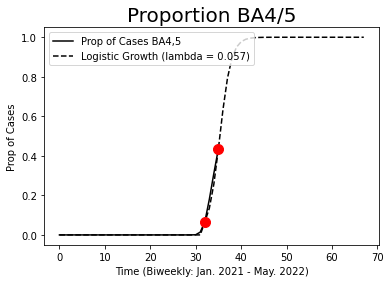

In [95]:
plt.plot(covid_vc["perc_ba45"], color='black', label='Prop of Cases BA4,5')
plt.plot(ba123_ba45, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.057)')
plt.xlabel('Time (Biweekly: Jan. 2021 - May. 2022)')
plt.ylabel('Prop of Cases')
plt.title("Proportion BA4/5", fontsize='20')
plt.plot(32, .0653, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(35, 0.4366, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.legend()

plt.savefig(r'/Users/JennyH/Documents/math690/figures/logistic_ba45.pdf', bbox_inches="tight")

In [72]:
covid_vc["logistic_perc_deltas"] = log( covid_vc["perc_deltas"]/(1-covid_vc["perc_deltas"]) )
covid_vc["logistic_perc_omicron"] = log(covid_vc["perc_omicrons"]/(1-covid_vc["perc_omicrons"]))
covid_vc["logistic_perc_ba45"] = log(covid_vc["perc_ba45"]/(1-covid_vc["perc_ba45"]))
covid_vc

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0,Unnamed: 0.1,week,total_sequences,deltas,omicrons,ba45,perc_deltas,perc_omicrons,perc_ba45,numDelta,numOmicron,numBA45,biweeklyDates,biweeklyCases,logistic_perc_deltas,logistic_perc_omicron,logistic_perc_ba45,date_time
0,0,0,2020-12-21,36771,11,0,0,0.000299,0.000000,0.000000,18.135297,0.000000,0.000000,Dec 21 2021,60623,-8.114270,-inf,-inf,2020-12-21
1,1,1,2021-01-11,35804,4,0,0,0.000112,0.000000,0.000000,4.172048,0.000000,0.000000,Jan 11 2021,37344,-9.099409,-inf,-inf,2021-01-11
2,2,2,2021-01-25,31768,1,0,0,0.000031,0.000000,0.000000,0.786357,0.000000,0.000000,Jan 25 2021,24981,-10.366183,-inf,-inf,2021-01-25
3,3,3,2021-02-08,34820,1,0,0,0.000029,0.000000,0.000000,0.767088,0.000000,0.000000,Feb 8 2021,26710,-10.457918,-inf,-inf,2021-02-08
4,4,4,2021-02-22,37323,2,0,0,0.000054,0.000000,0.000000,2.066715,0.000000,0.000000,Feb 22 2021,38568,-9.834164,-inf,-inf,2021-02-22
5,5,5,2021-03-08,48910,5,0,0,0.000102,0.000000,0.000000,7.936312,0.000000,0.000000,Mar 8 2021,77633,-9.188197,-inf,-inf,2021-03-08
6,6,6,2021-03-22,66582,23,0,0,0.000345,0.000000,0.000000,85.241837,0.000000,0.000000,Mar 22 2021,246764,-7.970350,-inf,-inf,2021-03-22
7,7,7,2021-04-05,77663,97,0,0,0.001249,0.000000,0.000000,869.539060,0.000000,0.000000,Apr 5 2021,696196,-6.684173,-inf,-inf,2021-04-05
8,8,8,2021-04-19,66041,467,0,0,0.007071,0.000000,0.000000,5381.775291,0.000000,0.000000,Apr 19 2021,761066,-4.944605,-inf,-inf,2021-04-19
9,9,9,2021-05-03,49602,837,0,0,0.016874,0.000000,0.000000,4314.156042,0.000000,0.000000,May 3 2021,255664,-4.064944,-inf,-inf,2021-05-03


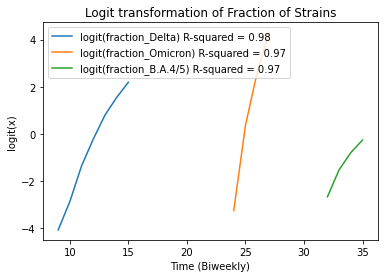

In [78]:
# According to page 4 of var_comp: Can we assume s(t) and r(t) are constant? 
fig, ax = plt.subplots()
ax.plot(covid_vc["logistic_perc_deltas"][9:16], label='logit(fraction_Delta) R-squared = 0.98')
ax.plot(covid_vc["logistic_perc_omicron"][24:28], label='logit(fraction_Omicron) R-squared = 0.97')
ax.plot(covid_vc["logistic_perc_ba45"][32:36], label='logit(fraction_B.A.4/5) R-squared = 0.97')
legend = ax.legend(loc='upper left')
plt.title('Logit transformation of Fraction of Strains')
plt.xlabel('Time (Biweekly)')
plt.ylabel('logit(x)')

fig.savefig(r'/Users/JennyH/Documents/math690/figures/logit_fraction_strains.pdf', bbox_inches="tight")
fig.savefig('logit_fraction_strains.pdf')

# How well does each logistic fit a line?
https://realpython.com/linear-regression-in-python/#simple-linear-regression

In [90]:
# Time units
days = 6*14 # two weeks
steps = 7 # number of data points
x = np.linspace(0, days,steps) # [ 0. 14. 28. 42. 56. 70. 84.]
# print(x)

y = covid_vc["logistic_perc_deltas"][9:16].tolist()
# print(y)

# Turn data into arrays.
x, y = np.array(x), np.array(y)
x = x.reshape(-1,1) # reshape x to be a list of features
# print(x)


# model_delta
model_delta = LinearRegression().fit(x, y)
model_delta

r_sq = model_delta.score(x, y)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_delta.intercept_}")
print(f"coefficients: {model_delta.coef_}")

coefficient of determination: 0.9812995686846585
intercept: -3.7508927012888424
coefficients: [0.07590549]


In [91]:
# Time units
days = 3*14 # two weeks
steps = 4 # number of data points
x = np.linspace(0, days,steps) # [ 0. 14. 28. 42. 56. 70. 84.]
# print(x)

y = covid_vc["logistic_perc_omicron"][24:28].tolist()

# Turn data into arrays.
x, y = np.array(x), np.array(y)
x = x.reshape(-1,1) # reshape x
# print(x)

# model_omicron
model_omicron = LinearRegression().fit(x, y)
model_omicron

r_sq = model_omicron.score(x, y)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_omicron.intercept_}")
print(f"coefficients: {model_omicron.coef_}")

coefficient of determination: 0.9703745491455967
intercept: -2.726752311834868
coefficients: [0.17792166]


In [92]:
# Time units
days = 3*14 # two weeks
steps = 4 # number of data points
x = np.linspace(0, days,steps) # [ 0. 14. 28. 42. 56. 70. 84.]
# print(x)

y = covid_vc["logistic_perc_ba45"][32:36].tolist()

# Turn data into arrays.
x, y = np.array(x), np.array(y)
x = x.reshape(-1,1) # reshape x
# print(x)

# model_ba45
model_ba45 = LinearRegression().fit(x, y)
model_ba45

r_sq = model_ba45.score(x, y)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_ba45.intercept_}")
print(f"coefficients: {model_ba45.coef_}")

coefficient of determination: 0.9705351360889637
intercept: -2.497213953845991
coefficients: [0.05675373]
